In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays, u_met
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
import pickle as pkl
import matplotlib.patches as patches


coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [254]:
cd ..

/home/ck/pythonWorkspace


In [333]:
pdf = pkl.load(open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))
box = np.array([-0.9,1.1,5.9,6.2])
pdf_all = pdf.where((pdf.clat >= box[2]) & (pdf.clat <= box[3]) & (pdf.clon >= box[0]) & (pdf.clon <= box[1]) &
                        (pdf.year >= 2000) & (pdf.year <= 2014) & 
                    ((pdf.month >= 3) & (pdf.month <= 5)) | ((pdf.month >= 9) & (pdf.month <= 11)))
pdf_all = pdf_all.dropna()

pdf_march = pdf.where((pdf.clat >= box[2]) & (pdf.clat <= box[3]) & (pdf.clon >= box[0]) & (pdf.clon <= box[1]) &
                        (pdf.year >= 2000) & (pdf.year <= 2014) & (pdf.month == 5))
pdf_march = pdf_march.dropna()

pdf_oct = pdf.where((pdf.clat >= box[2]) & (pdf.clat <=box[3]) & (pdf.clon >= box[0]) & (pdf.clon <= box[1]) &
                        (pdf.year >= 2000) & (pdf.year <= 2014) & (pdf.month == 10))
pdf_oct = pdf_oct.dropna()

In [334]:
pdf_all.keys()

Index(['date', 'month', 'year', 'area', '70area', 'minlon', 'minlat', 'maxlon',
       'maxlat', 'clon', 'clat', 'tmin', 'tmean', 't10', 't90'],
      dtype='object')

In [335]:
len(pdf_all)

53617

In [312]:
dates_all = pdf_all.date
dates_mar = pdf_march.date
dates_oct = pdf_oct.date

In [313]:
def cut_kernel(xpos, ypos, arr, date, lon, lat):

    #AMSRE 0.25 degrees ~ 27.5 km
    dist = 10

    kernel = u_arrays.cut_kernel(arr,xpos, ypos,dist)


    # if (np.sum(np.isfinite(kernel)) < 0.10 * kernel.size):
    #     return

    kernel3 = kernel - np.nanmean(kernel)

    cnt = np.zeros_like(kernel)
    cnt[np.isfinite(kernel)] = 1

    if kernel.shape != (dist*2+1, dist*2+1):
        return None

    return kernel, kernel3, cnt

In [314]:
def run(shift, hour,tab,ibox):
    dic = {
    'q' : [],
    't' : [],
    'u' : [],
    'v' : [],
    'w' : [],
    'u_orig' : [],
    'v_orig' : [],        
    'w_orig' : [],  
    'd' : [],
    't2' : [],
    'u100' : [],
    'v100' : [],
    'u100_orig' : [],
    'v100_orig' : [],
    'slp' : [],
    'cnt' : [],
    'mcc' : [],
    'hcc' : [],
    'cape' : [],
    'divMoist' : [],
    'ice' : [],
    'ice_orig' : [],
    'sh' : [],
    'rh' : [],
    'zshear' : [],
    'pv'    : [],
    'pv_clim'    : [],
    'pv_orig' : [],
        
    'q_clim' : [],
    't_clim' : [],
    'u_clim' : [],
    'v_clim' : [],
    'w_clim' : [],
    'd_clim' : [],
    't2_clim' : [],
    'u100_clim' : [],
    'v100_clim' : [],
    'slp_clim' : [],
    'mcc_clim' : [],
    'hcc_clim' : [],
    'cape_clim' : [],
    'divMoist_clim' : [],
    'ice_clim' : [],
    'sh_clim' : [],
    'rh_clim' : [],
    'zshear_clim' : []
    }
    
    clim = '/home/ck/DIR/mymachine/ERA5/monthly/synop_selfmade/CLIM_2000-2014/'
    
    #box = [-4.5,3.5,9,15] #ouaga
    box = [-7.5,7.5,4,15] # WA



    for date in tab:


        single = tab[tab==date]
       
        dt = pd.to_datetime(date)
        
        
        daystring = str(abs(shift))
        dayd = pd.Timedelta(daystring + 'days')
        if shift < 0:
            dt = dt - dayd
        if shift >=0:
            dt = dt + dayd
            
        window1 = dt - pd.Timedelta('7days')
        window2 = dt + pd.Timedelta('7days')
        

        fdate = '_' + str(dt.year) +'_' + str(dt.month).zfill(2) + '_'# + str(dt.day).zfill(2)
        
        hour = hour
        shour = hour

        try:

            lsta = xr.open_dataset(cnst.ERA5 + 'hourly/pressure_levels/ERA5' + fdate + 'pl.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            lsta_clim = xr.open_dataset(clim + \
                            'pressure_levels/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_pl.nc')
            
            srfc = xr.open_dataset(cnst.ERA5 + 'hourly/surface/ERA5' + fdate + 'srfc.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            srfc_clim = xr.open_dataset(clim + \
                            'surface/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_srfc.nc')

        except:
            print('File missing', cnst.ERA5  + 'hourly/pressure_levels/ERA5' + fdate + 'pl.nc')
            continue
            
        lsta = u_darrays.flip_lat(lsta)
        srfc = u_darrays.flip_lat(srfc)
        

        lsta = lsta.sel(longitude=slice(ibox[0], ibox[1]), latitude=slice(box[2],box[3])).mean('longitude')
        lsta_clim = lsta_clim.sel(lon=slice(ibox[0], ibox[1]), lat=slice(box[2],box[3])).mean('lon')
        
        srfc = srfc.sel(longitude=slice(ibox[0], ibox[1]), latitude=slice(box[2],box[3])).mean('longitude')
        srfc_clim = srfc_clim.sel(lon=slice(ibox[0], ibox[1]), lat=slice(box[2],box[3])).mean('lon')
        
        pos = np.where(lsta['time.hour']==shour)
        if np.sum(pos) == 0:
            continue
        
        try:
            lsta_low = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        except:
            continue
        lsta_up = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        
        srfc_low = srfc.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        
        lsta10 = lsta.isel(time=pos[0])
        lsta10_low = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'))
        

        
#         lsta10_low = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=925)
        
#         lsta10_up = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=650)
        
        
        
        
        pos = np.where(srfc['time.hour']==shour)
        #ipdb.set_trace()
        srfc10 = srfc.isel(time=pos[0])
        srfc10 = srfc10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'))
     
        
#         srfc10 = srfc.isel(time=pos[0])
#         srfc10 = srfc10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00' )
     
        
        
        
        lsta_clim_low = lsta_clim
        
        #ipdb.set_trace()

        q = lsta_low['q'].squeeze()
        pv = lsta_low['pv'].squeeze()
        u = lsta_low['u'].squeeze()
        v = lsta_low['v'].squeeze()
        w = lsta_low['w'].squeeze()
        t = lsta_low['t'].squeeze()
        d = lsta_low['d'].squeeze()
        rh = lsta_low['r'].squeeze()
        t2 = srfc_low['t2m'].squeeze()
        u100 = srfc_low['u10'].squeeze()
        v100 = srfc_low['v10'].squeeze()
        slp = srfc_low['sp'].squeeze()
        cape = srfc_low['cape'].squeeze()
        hcc = srfc_low['hcc'].squeeze()
        mcc = srfc_low['mcc'].squeeze()
        divMoist = srfc_low['p84.162'].squeeze()
        ice = srfc_low['tciw'].squeeze()
        sh = srfc_low['ishf'].squeeze()
        
        q_clim = lsta10_low['q'].squeeze().mean('time')
        pv_clim = lsta10_low['pv'].squeeze().mean('time')
        u_clim = lsta10_low['u'].squeeze().mean('time')
        v_clim = lsta10_low['v'].squeeze().mean('time')
        w_clim = lsta10_low['w'].squeeze().mean('time')
        t_clim = lsta10_low['t'].squeeze().mean('time')
        rh_clim = lsta10_low['r'].squeeze().mean('time')
        d_clim = lsta10_low['d'].squeeze().mean('time')
        t2_clim = srfc10['t2m'].squeeze().mean('time')
        u100_clim = srfc10['u10'].squeeze().mean('time')
        v100_clim = srfc10['v10'].squeeze().mean('time')
        slp_clim = srfc10['sp'].squeeze().mean('time')
        cape_clim = srfc10['cape'].squeeze().mean('time')
        hcc_clim = srfc10['hcc'].squeeze().mean('time')
        mcc_clim = srfc10['mcc'].squeeze().mean('time')
        divMoist_clim = srfc10['p84.162'].squeeze().mean('time')
        ice_clim = srfc10['tciw'].squeeze().mean('time')
        sh_clim = srfc10['ishf'].squeeze().mean('time')
        
#         q_clim = lsta10_low['q'].squeeze()
#         u_clim = lsta10_up['u'].squeeze()
#         v_clim = lsta10_up['v'].squeeze()
#         w_clim = lsta10_low['w'].squeeze()
#         t_clim = lsta10_low['t'].squeeze()
#         rh_clim = lsta10_low['r'].squeeze()
#         d_clim = lsta10_low['d'].squeeze()
#         t2_clim = srfc10['t2m'].squeeze()
#         u100_clim = srfc10['u100'].squeeze()
#         v100_clim = srfc10['v100'].squeeze()
#         slp_clim = srfc10['sp'].squeeze()
#         cape_clim = srfc10['cape'].squeeze()
#         hcc_clim = srfc10['hcc'].squeeze()
#         mcc_clim = srfc10['mcc'].squeeze()
#         divMoist_clim = srfc10['p84.162']
#         ice_clim = srfc10['tciw'].squeeze()
#         sh_clim = srfc10['ishf'].squeeze()

#         q_clim = lsta_clim_low['q'].squeeze()
#         u_clim = lsta_clim_up['u'].squeeze()
#         v_clim = lsta_clim_up['v'].squeeze()
#         t_clim = lsta_clim_low['t'].squeeze()
#         d_clim = lsta_clim_low['d'].squeeze()
#         t2_clim = srfc_clim['t2m'].squeeze()
#         u100_clim = srfc_clim['u100'].squeeze()
#         v100_clim = srfc_clim['v100'].squeeze()
#         slp_clim = srfc_clim['msl'].squeeze()

        print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
        dt.day).zfill(2) + '.nc')

        cnt = np.zeros_like(q.values)
        cnt[np.isfinite(q.values)] = 1

        dic['q'].append(q.values- q_clim.values)
        dic['pv'].append(pv.values- pv_clim.values)
        dic['pv_orig'].append(pv.values)
        dic['v'].append(v.values- v_clim.values)
        dic['w'].append(w.values- w_clim.values)
        dic['u'].append(u.values- u_clim.values)
        dic['rh'].append(rh.values- rh_clim.values)
        dic['v_orig'].append(v.values)#
        dic['u_orig'].append(u.values)#
        dic['w_orig'].append(w.values)#
        dic['t'].append(t.values-t_clim.values)
        dic['d'].append(d.values-d_clim.values)
        dic['t2'].append(t2.values-t2_clim.values)
        dic['u100'].append(u100.values-u100_clim.values)
        dic['v100'].append(v100.values-v100_clim.values)
        dic['u100_orig'].append(u100.values)#
        dic['v100_orig'].append(v100.values)#
        dic['slp'].append(slp.values-slp_clim.values)
        dic['cape'].append(cape.values-cape_clim.values)#s-v100_clim.values)
        dic['hcc'].append(hcc.values-hcc_clim.values)
        dic['mcc'].append(mcc.values-mcc_clim.values)
        dic['divMoist'].append(divMoist.values-divMoist_clim.values)#-slp_clim.values)
        dic['ice'].append(ice.values-ice_clim.values)
        dic['ice_orig'].append(ice.values)
        dic['sh'].append(sh.values-sh_clim.values)
        ws, wd = u_met.u_v_to_ws_wd(u.values-u100.values, v.values-v100.values)
        wsclim, wd = u_met.u_v_to_ws_wd(u_clim.values-u100_clim.values, v_clim.values-v100_clim.values)
        dic['zshear'].append(ws-wsclim)
        
        dic['q_clim'].append(q_clim.values)
        dic['pv_clim'].append(pv_clim.values)
        dic['v_clim'].append(v_clim.values)
        dic['w_clim'].append(w_clim.values)
        dic['u_clim'].append(u_clim.values)
        dic['rh_clim'].append(rh_clim.values)
        dic['t_clim'].append(t_clim.values)
        dic['d_clim'].append(d_clim.values)
        dic['t2_clim'].append(t2_clim.values)
        dic['u100_clim'].append(u100_clim.values)
        dic['v100_clim'].append(v100_clim.values)
        dic['slp_clim'].append(slp_clim.values)
        dic['cape_clim'].append(cape_clim.values)#s-v100_clim.values)
        dic['hcc_clim'].append(hcc_clim.values)
        dic['mcc_clim'].append(mcc_clim.values)
        dic['divMoist_clim'].append(divMoist_clim.values)#-slp_clim.values)
        dic['ice_clim'].append(ice_clim.values)
        dic['sh_clim'].append(sh_clim.values)

        dic['zshear_clim'].append(wsclim)
        dic['cnt'].append(cnt)

        lat = lsta_low.latitude.values
        level = lsta.level.values
    
    for k in dic.keys():
        dic[k] = np.nansum(np.stack(dic[k], axis=0), axis=0)

    return dic, lat, level

In [315]:
def calc(dic):
    
    dics = {}
    for k in dic.keys():
        if k == 'cnt':
            continue
        dics[k] = dic[k] / dic['cnt']
    return dics

In [316]:
dic, lat, level = run(0,12,dates_mar, box)
dic = calc(dic)

Doing AMSR_20000504.nc
Doing AMSR_20000508.nc
Doing AMSR_20000511.nc
Doing AMSR_20000512.nc
Doing AMSR_20000515.nc
Doing AMSR_20000516.nc
Doing AMSR_20000516.nc
Doing AMSR_20010502.nc
Doing AMSR_20010514.nc
Doing AMSR_20010515.nc
Doing AMSR_20010519.nc
Doing AMSR_20010519.nc
Doing AMSR_20010524.nc
Doing AMSR_20010528.nc
Doing AMSR_20010528.nc
Doing AMSR_20010530.nc
Doing AMSR_20020501.nc
Doing AMSR_20020502.nc
Doing AMSR_20020502.nc
Doing AMSR_20020504.nc
Doing AMSR_20020508.nc
Doing AMSR_20020508.nc
Doing AMSR_20020516.nc
Doing AMSR_20020520.nc
Doing AMSR_20020520.nc
Doing AMSR_20020521.nc
Doing AMSR_20020528.nc
Doing AMSR_20030504.nc
Doing AMSR_20030505.nc
Doing AMSR_20030506.nc
Doing AMSR_20030506.nc
Doing AMSR_20030507.nc
Doing AMSR_20030511.nc
Doing AMSR_20030528.nc
Doing AMSR_20030530.nc
Doing AMSR_20030530.nc
Doing AMSR_20040504.nc
Doing AMSR_20040505.nc
Doing AMSR_20040505.nc
Doing AMSR_20040506.nc
Doing AMSR_20040508.nc
Doing AMSR_20040509.nc
Doing AMSR_20040512.nc
Doing AMSR_

In [324]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, **kwargs, extend='both')  # this is the actual plot
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=10)
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

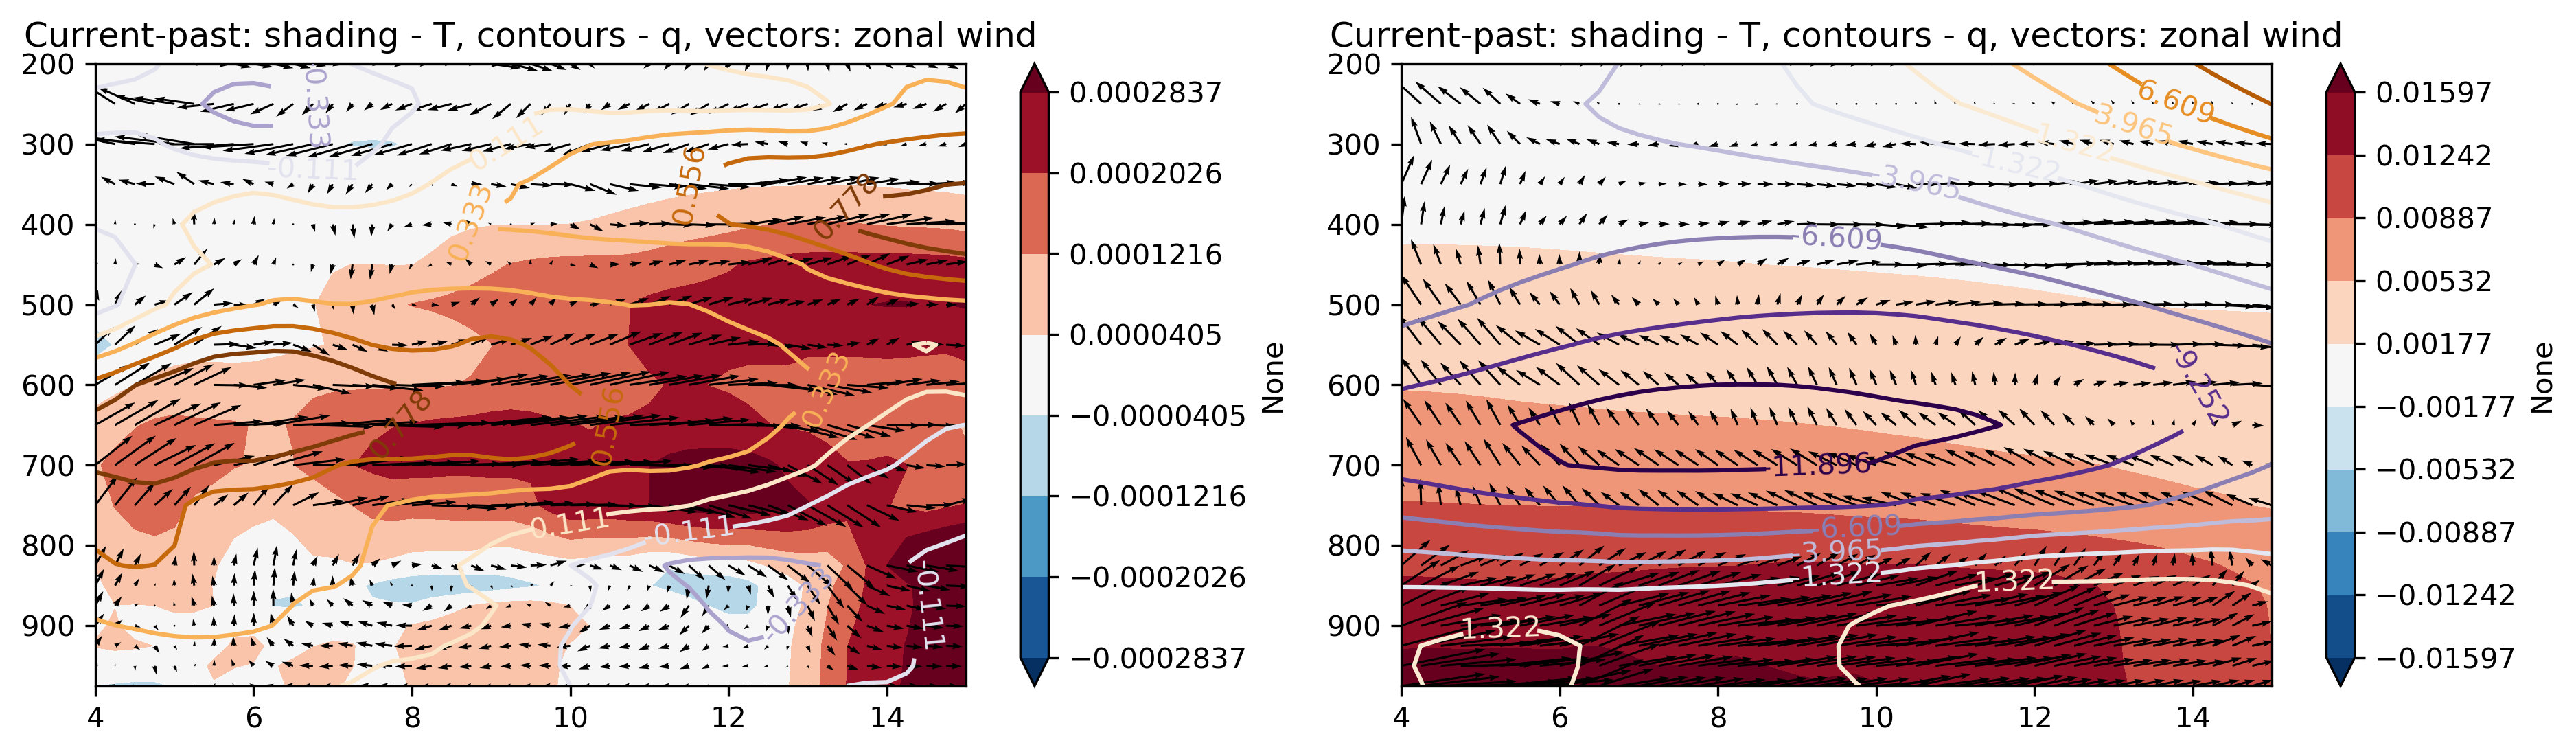

In [328]:
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(121)
# "current zonal wind" wind vectors
vano = dic['v']
wano = dic['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=1
sarrow = 1


lat2d, lev2d = np.meshgrid(lat,level)

xquiv = lat#[sarrow::st, sarrow::st]
yquiv = level#[sarrow::st, sarrow::st]

uu = (vano)#[::, sarrow::st]  
ww = (wano)#[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 10}

# temperature and moisture check
var = dic['q']
cvar = dic['u']
edge = np.max([np.abs(np.percentile(cvar,5)),np.abs(np.percentile(cvar,95))])
levs = np.linspace(edge*-1,edge,8)

edge = np.max([np.abs(np.percentile(var,5)),np.abs(np.percentile(var,95))])
#edge = 20
lev = np.linspace(edge*-1,edge,8) # 

contour = {'data' : cvar, 'x' : lat, 'y' : level, 'levels' : levs, 'cmap' : 'PuOr_r'}
draw_cross(ax, var, lat, level, cmap='RdBu_r', levels=lev,
            quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

###############

ax = f.add_subplot(122)
# "current zonal wind" wind vectors
vano = dic['v_orig']
wano = dic['w_orig']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=1
sarrow = 1


lat2d, lev2d = np.meshgrid(lat,level)

xquiv = lat#[sarrow::st, sarrow::st]
yquiv = level#[sarrow::st, sarrow::st]

uu = (vano)#[::, sarrow::st]  
ww = (wano)#[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

# temperature and moisture check
var = dic['q_clim']
cvar = dic['u_clim']
edge = np.max([np.abs(np.percentile(cvar,5)),np.abs(np.percentile(cvar,95))])
#edge = 70
levs = np.linspace(edge*-1,edge,10)

edge = np.max([np.abs(np.percentile(var,5)),np.abs(np.percentile(var,95))])

#edge = 20
lev = np.linspace(edge*-1,edge,10) # 

contour = {'data' : cvar, 'x' : lat, 'y' : level, 'levels' : levs, 'cmap' : 'PuOr_r'}
draw_cross(ax, var, lat, level, cmap='RdBu_r', levels=lev,
            quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

In [329]:
dico, lato, levelo = run(0,12,dates_oct, box)
dico = calc(dico)

Doing AMSR_20001001.nc
Doing AMSR_20001002.nc
Doing AMSR_20001003.nc
Doing AMSR_20001004.nc
Doing AMSR_20001006.nc
Doing AMSR_20001007.nc
Doing AMSR_20001009.nc
Doing AMSR_20001013.nc
Doing AMSR_20001014.nc
Doing AMSR_20001017.nc
Doing AMSR_20001022.nc
Doing AMSR_20001023.nc
Doing AMSR_20001023.nc
Doing AMSR_20001024.nc
Doing AMSR_20001025.nc
Doing AMSR_20001027.nc
Doing AMSR_20001028.nc
Doing AMSR_20001031.nc
Doing AMSR_20011007.nc
Doing AMSR_20011011.nc
Doing AMSR_20011013.nc
Doing AMSR_20011013.nc
Doing AMSR_20011014.nc
Doing AMSR_20011016.nc
Doing AMSR_20011017.nc
Doing AMSR_20011018.nc
Doing AMSR_20011021.nc
Doing AMSR_20011022.nc
Doing AMSR_20011023.nc
Doing AMSR_20011024.nc
Doing AMSR_20011025.nc
Doing AMSR_20011027.nc
Doing AMSR_20021012.nc
Doing AMSR_20021013.nc
Doing AMSR_20021014.nc
Doing AMSR_20021015.nc
Doing AMSR_20021019.nc
Doing AMSR_20021021.nc
Doing AMSR_20021022.nc
Doing AMSR_20021024.nc
Doing AMSR_20021024.nc
Doing AMSR_20021025.nc
Doing AMSR_20021025.nc
Doing AMSR_

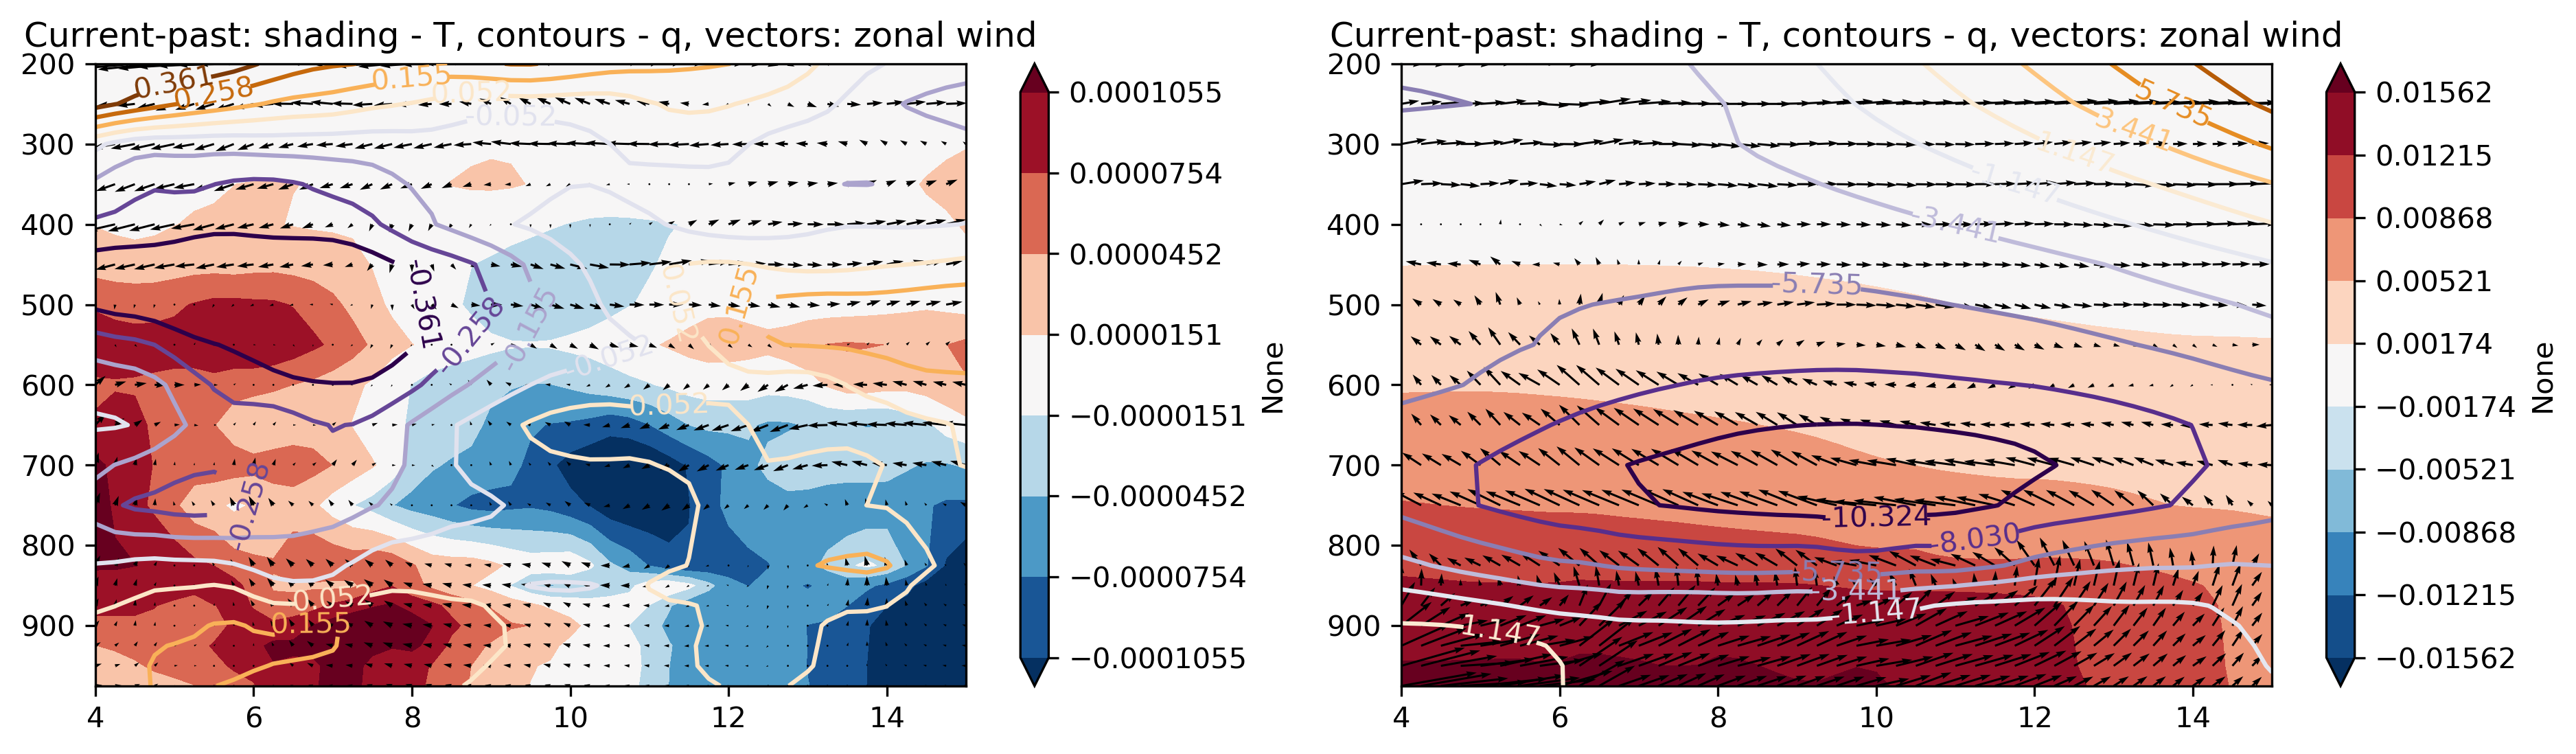

In [331]:
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(121)
# "current zonal wind" wind vectors
vano = dico['v']
wano = dico['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=1
sarrow = 1


lat2d, lev2d = np.meshgrid(lat,level)

xquiv = lat#[sarrow::st, sarrow::st]
yquiv = level#[sarrow::st, sarrow::st]

uu = (vano)#[::, sarrow::st]  
ww = (wano)#[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 10}

# temperature and moisture check
var = dico['q']
cvar = dico['u']
edge = np.max([np.abs(np.percentile(cvar,5)),np.abs(np.percentile(cvar,95))])
levs = np.linspace(edge*-1,edge,8)

edge = np.max([np.abs(np.percentile(var,5)),np.abs(np.percentile(var,95))])
#edge = 20
lev = np.linspace(edge*-1,edge,8) # 

contour = {'data' : cvar, 'x' : lat, 'y' : level, 'levels' : levs, 'cmap' : 'PuOr_r'}
draw_cross(ax, var, lat, level, cmap='RdBu_r', levels=lev,
            quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

###############

ax = f.add_subplot(122)
# "current zonal wind" wind vectors
vano = dico['v_orig']
wano = dico['w_orig']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=1
sarrow = 1


lat2d, lev2d = np.meshgrid(lat,level)

xquiv = lat#[sarrow::st, sarrow::st]
yquiv = level#[sarrow::st, sarrow::st]

uu = (vano)#[::, sarrow::st]  
ww = (wano)#[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

# temperature and moisture check
var = dico['q_clim']
cvar = dico['u_clim']
edge = np.max([np.abs(np.percentile(cvar,5)),np.abs(np.percentile(cvar,95))])
levs = np.linspace(edge*-1,edge,10)

edge = np.max([np.abs(np.percentile(var,5)),np.abs(np.percentile(var,95))])
#edge = 20
lev = np.linspace(edge*-1,edge,10) # 

contour = {'data' : cvar, 'x' : lat, 'y' : level, 'levels' : levs, 'cmap' : 'PuOr_r'}
draw_cross(ax, var, lat, level, cmap='RdBu_r', levels=lev,
            quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

## 